In [1]:
import os
import re
from typing import List, Union, Any
from dataclasses import dataclass
import numpy as np
import pandas as pd
from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel

In [2]:
articles_df = pd.read_csv("articles.csv")
print(f"Num. articles: {len(articles_df)}")
print(f"Unique articles: {len(articles_df.article_id.unique().tolist())}")
print(f"Columns: {list(articles_df.columns)}")
articles_df.head()


Num. articles: 105542
Unique articles: 105542
Columns: ['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
articles_df.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [4]:
articles_df["detail_desc"] = articles_df["detail_desc"].fillna("")

In [5]:
customers_df = pd.read_csv("customers.csv")
print(f"Num. customers: {len(customers_df)}")
print(f"Unique customers: {len(customers_df.customer_id.unique().tolist())}")
print(f"Columns: {list(customers_df.columns)}")
customers_df.head()

Num. customers: 1371980
Unique customers: 1371980
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
customers_df.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [7]:
customers_df["Active"] = customers_df["Active"].fillna(0)

<Axes: title={'center': 'Customers age distribution'}>

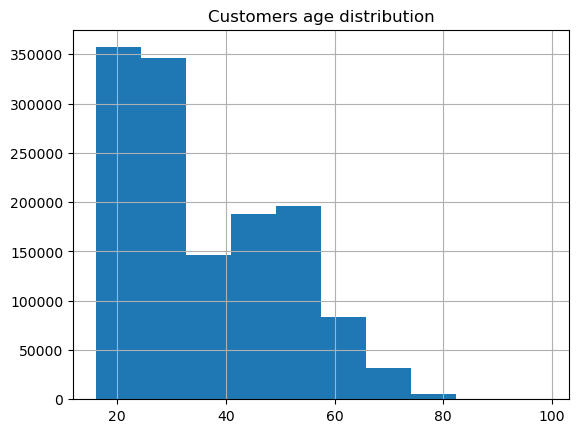

In [8]:
plt.title("Customers age distribution")
customers_df["age"].hist()

In [9]:
transactions_df = pd.read_csv("transactions_train.csv")
print(f"Num. transactions: {len(transactions_df)}")
print(f"Columns: {list(transactions_df.columns)}")
transactions_df

Num. transactions: 31788324
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [10]:
transactions_df.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [11]:
transactions_df["price"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
)

count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
10%      1.010169e-02
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
90%      5.083051e-02
max      5.915254e-01
Name: price, dtype: float64

In [12]:
text_cols = [
    "prod_name",
    "product_type_name",
    "product_group_name",
    "graphical_appearance_name",
    "colour_group_name",
    "department_name",
    "index_name",
    "detail_desc",
]

In [13]:
def merge_text_columns(row, columns):
    texts = []
    
    # Looping through the columns except for `detail_desc`.
    # It will be appended with a '-' separator.
    for col in columns[:-1]:
        texts.append(row[col])
        
    texts = ", ".join(texts)
    texts = " - ".join([texts, row[columns[-1]]])
    
    return texts

In [14]:
articles_df["text"] = articles_df.apply(lambda row: merge_text_columns(row, text_cols), axis=1)
articles_df["text"].head()

0    Strap top, Vest top, Garment Upper body, Solid...
1    Strap top, Vest top, Garment Upper body, Solid...
2    Strap top (1), Vest top, Garment Upper body, S...
3    OP T-shirt (Idro), Bra, Underwear, Solid, Blac...
4    OP T-shirt (Idro), Bra, Underwear, Solid, Whit...
Name: text, dtype: object

In [15]:
articles_df["text"] = articles_df["text"].apply(lambda text: text.strip().lower())
articles_df["text"].head()

0    strap top, vest top, garment upper body, solid...
1    strap top, vest top, garment upper body, solid...
2    strap top (1), vest top, garment upper body, s...
3    op t-shirt (idro), bra, underwear, solid, blac...
4    op t-shirt (idro), bra, underwear, solid, whit...
Name: text, dtype: object

In [16]:
# Path to your GloVe file
glove_file_path = 'glove.6B.100d.txt'

# Function to load GloVe word vectors into a dictionary
def load_glove_embeddings(file_path):
    glove_embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings_index[word] = vector
    return glove_embeddings_index

# Load GloVe word vectors into glove_embeddings_index
glove_embeddings_index = load_glove_embeddings(glove_file_path)


In [17]:
texts = articles_df['text'].tolist()

In [18]:
import numpy as np

# Assuming you have a DataFrame 'embedded_articles' with a column 'text' containing article descriptions
# Also, 'glove_embeddings_index' contains loaded GloVe embeddings

# Function to get GloVe embeddings for individual words
def get_glove_embedding_for_word(word, glove_embeddings_index):
    embedding_dim = 100  # Adjust this based on the GloVe dimension you are using
    return glove_embeddings_index.get(word.lower(), np.zeros(embedding_dim))

# Function to generate GloVe embeddings for a list of texts
def get_glove_embedding_for_texts(texts, glove_embeddings_index):
    embedding_dim = 100  # Adjust this based on the GloVe dimension you are using

    embeddings = []
    for text in texts:
        words = text.split(', ')  # Split text into tokens
        text_embedding = np.zeros(embedding_dim)
        word_count = len(words) if len(words) > 0 else 1  # Ensure non-zero division

        for word in words:
            word_embedding = get_glove_embedding_for_word(word, glove_embeddings_index)
            text_embedding += word_embedding
        
        text_embedding /= word_count  # Average of word vectors
        embeddings.append(text_embedding)

    return np.array(embeddings)

# Sample text data from the DataFrame column 'text'
texts_for_embedding = articles_df['text'].tolist()

# Generate GloVe embeddings for the texts in the DataFrame
glove_embeddings_for_articles = get_glove_embedding_for_texts(texts_for_embedding, glove_embeddings_index)

# Update 'embedded_articles' DataFrame with GloVe embeddings
articles_df['glove_embedding'] = glove_embeddings_for_articles.tolist()



In [34]:
articles_df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'text',
       'glove_embedding'],
      dtype='object')

In [20]:
print("Num. embedded articles:", len(articles_df['glove_embedding']))

Num. embedded articles: 105542


In [35]:
embedded_articles = articles_df[['article_id','text','glove_embedding','index_group_name']]

In [36]:
# Getting the subset of `transactions_train.csv` which has these particular article IDs.
sample_transaction_df = transactions_df[
    transactions_df["article_id"].isin(
        embedded_articles["article_id"].tolist()
    )
]

In [37]:
sample_transaction_df

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [38]:
print("Num. of transactions with these article IDs:", len(sample_transaction_df))

Num. of transactions with these article IDs: 31788324


In [39]:
embedded_articles

,article_id,text,glove_embedding,index_group_name
0,108775015,"strap top, vest top, garment upper body, solid...","[-0.06862656931791987, 0.2076928530420576, 0.0...",Ladieswear
1,108775044,"strap top, vest top, garment upper body, solid...","[-0.08446285554340907, 0.17268142529896327, 0....",Ladieswear
2,108775051,"strap top (1), vest top, garment upper body, s...","[-0.07080857242856707, 0.0953200033732823, -0....",Ladieswear
3,110065001,"op t-shirt (idro), bra, underwear, solid, blac...","[-0.02006732879413499, 0.2904311070839564, -0....",Ladieswear
4,110065002,"op t-shirt (idro), bra, underwear, solid, whit...","[-0.032384440302848816, 0.26319999661710525, -...",Ladieswear
...,...,...,...,...
105537,953450001,"5pk regular placement1, socks, socks & tights,...","[0.05404771279011454, 0.1528771391936711, 0.04...",Menswear
105538,953763001,"sport malaga tank, vest top, garment upper bod...","[0.06845200540763992, 0.13501142604010447, 0.0...",Ladieswear
105539,956217002,"cartwheel dress, dress, garment full body, sol...","[0.06823933828208181, 0.10873710902200805, 0.0...",Ladieswear
105540,957375001,"claire hair claw, hair clip, accessories, soli...","[-0.09757228355322566, 0.26828713927950176, 0....",Divided


In [40]:
embedded_transactions = sample_transaction_df.merge(
    embedded_articles, 
    how="left", left_on="article_id", right_on="article_id"
)[[
    "customer_id",
    "article_id",
    "price",
    "glove_embedding",
    "index_group_name"
]]

In [41]:
embedded_transactions

,customer_id,article_id,price,glove_embedding,index_group_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,"[-0.00832781432704492, 0.22209272330457513, -0...",Ladieswear
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,"[-0.013684439990255568, 0.21421444250477684, -...",Ladieswear
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,"[-0.10012000054121017, 0.15623100101947784, 0....",Divided
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,"[-0.20588999800384045, 0.23406000062823296, -0...",Ladieswear
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,"[-0.15534374676644802, 0.17841000109910965, -0...",Ladieswear
...,...,...,...,...,...
31788319,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,"[-0.03852872652086345, 0.1484785442325202, -0....",Divided
31788320,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,"[-0.09407545321367004, 0.2062974524768916, 0.0...",Divided
31788321,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,"[-0.12447449890896678, 0.22426374815404415, 0....",Ladieswear
31788322,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,"[0.18387429203305924, 0.30917671588914736, -0....",Ladieswear


In [42]:
embedded_customer_ids = embedded_transactions["customer_id"].unique().tolist()
print(f"Num. Customers in the embedded transactions: {len(embedded_customer_ids)}")

Num. Customers in the embedded transactions: 1362281


In [43]:
embedded_transactions['glove_embedding']

0           [-0.00832781432704492, 0.22209272330457513, -0...
1           [-0.013684439990255568, 0.21421444250477684, -...
2           [-0.10012000054121017, 0.15623100101947784, 0....
3           [-0.20588999800384045, 0.23406000062823296, -0...
4           [-0.15534374676644802, 0.17841000109910965, -0...
                                  ...                        
31788319    [-0.03852872652086345, 0.1484785442325202, -0....
31788320    [-0.09407545321367004, 0.2062974524768916, 0.0...
31788321    [-0.12447449890896678, 0.22426374815404415, 0....
31788322    [0.18387429203305924, 0.30917671588914736, -0....
31788323    [-0.00820733399854766, 0.24062665965822008, -0...
Name: glove_embedding, Length: 31788324, dtype: object

In [44]:
subset_transactions = embedded_transactions.sample(frac=0.1)  # Use a fraction (e.g., 10%) of your data
subset_transactions['glove_embedding'] = subset_transactions['glove_embedding'].apply(np.array)
customer_embeddings = subset_transactions.groupby('customer_id')['glove_embedding'].apply(lambda emb: np.mean(emb)).reset_index()

In [45]:
customer_embeddings

,customer_id,glove_embedding
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0..."
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[-0.10132755980723435, 0.13979744331704247, -0..."
2,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[-0.06862656931791987, 0.2076928530420576, 0.0..."
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0.08443749696016312, 0.10857000201940536, -0...."
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[-0.10884125837612721, 0.1531295715142337, -0...."
...,...,...
821699,ffff61677073258d461e043cc9ed4ed97be5617a920640...,"[-0.1153779248229016, 0.14898424431110027, -0...."
821700,ffff64f7850d4268016db8db3d48bf5433db2a926ba71b...,"[0.051198999583721164, 0.10869700312614441, -0..."
821701,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0.011710433086211032, 0.12251692139552231, -0..."
821702,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[-0.051308487883951294, 0.19631151508349381, -..."


In [46]:
embedded_transactions

,customer_id,article_id,price,glove_embedding,index_group_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,"[-0.00832781432704492, 0.22209272330457513, -0...",Ladieswear
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,"[-0.013684439990255568, 0.21421444250477684, -...",Ladieswear
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,"[-0.10012000054121017, 0.15623100101947784, 0....",Divided
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,"[-0.20588999800384045, 0.23406000062823296, -0...",Ladieswear
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,"[-0.15534374676644802, 0.17841000109910965, -0...",Ladieswear
...,...,...,...,...,...
31788319,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,"[-0.03852872652086345, 0.1484785442325202, -0....",Divided
31788320,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,"[-0.09407545321367004, 0.2062974524768916, 0.0...",Divided
31788321,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,"[-0.12447449890896678, 0.22426374815404415, 0....",Ladieswear
31788322,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,"[0.18387429203305924, 0.30917671588914736, -0....",Ladieswear


In [47]:
# Group the article IDs based on the customer ID.
embedded_transactions["index_group_name"] = embedded_transactions["index_group_name"]
bought_articles = embedded_transactions.groupby(["customer_id"]).agg({
    "index_group_name": ",".join
})
bought_articles.head()


,index_group_name
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,"Baby/Children,Menswear,Baby/Children,Baby/Chil..."
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,"Divided,Ladieswear,Divided,Divided,Ladieswear,..."
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,"Ladieswear,Ladieswear,Ladieswear,Ladieswear,La..."
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,"Sport,Sport"
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,"Ladieswear,Ladieswear,Ladieswear,Ladieswear,La..."


In [48]:
# Group the article IDs based on the customer ID.
embedded_transactions["article_id"] = embedded_transactions["article_id"].astype(str)
bought_articles = embedded_transactions.groupby(["customer_id"]).agg({
    "article_id": ",".join
})
bought_articles.head()


,article_id
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,"625548001,176209023,627759010,697138006,568601..."
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,"583558001,639677008,640244003,521269001,666448..."
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,"663713001,541518023,663713001,578020002,723529..."
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,"742079001,732413001"
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,"634249005,677049001,698286003,707704003,399061..."


In [49]:
# Add the list of bought articles into the `customer_embeddings` DataFrame.
# Here, it doesn't matter if it is inner, left or right, since the customer IDs are the same.
customer_embeddings= customer_embeddings.merge(bought_articles, how="left", left_on="customer_id", right_on="customer_id")
customer_embeddings.head()

,customer_id,glove_embedding,article_id
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...","583558001,639677008,640244003,521269001,666448..."
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[-0.10132755980723435, 0.13979744331704247, -0...","663713001,541518023,663713001,578020002,723529..."
2,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[-0.06862656931791987, 0.2076928530420576, 0.0...","738133005,680265002,740962001"
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0.08443749696016312, 0.10857000201940536, -0....","735843004,726925001,715624008,783388001,719530..."
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[-0.10884125837612721, 0.1531295715142337, -0....","505221004,685687003,685687004,685687001,505221..."


In [50]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
embeddings_array = np.array(customer_embeddings['glove_embedding'].tolist())
max_clusters = 10 
wcss = []

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(embeddings_array)
    wcss.append(kmeans.inertia_)  

C:\Users\tannn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tannn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tannn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tannn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

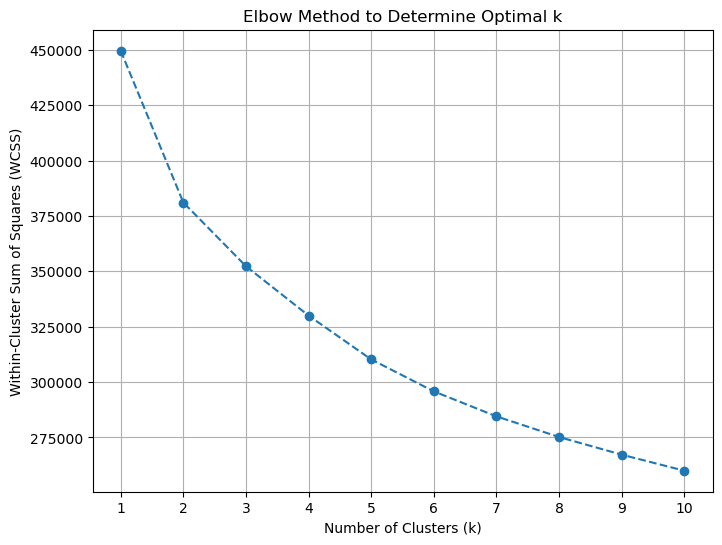

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method to Determine Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [52]:
customer_embeddings['customer_id'][4]

'00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2'

In [53]:
from sklearn.metrics.pairwise import euclidean_distances

embeddings_array = np.array(customer_embeddings['glove_embedding'].tolist())

In [54]:
embeddings_array

array([[-0.04461103,  0.18000859, -0.04424998, ..., -0.07769368,
         0.03724938,  0.07259571],
       [-0.10132756,  0.13979744, -0.05311772, ..., -0.06431617,
         0.10287111,  0.13372833],
       [-0.06862657,  0.20769285,  0.01381157, ..., -0.06152014,
         0.04211   ,  0.08541571],
       ...,
       [ 0.01171043,  0.12251692, -0.01441708, ..., -0.0350717 ,
         0.14641164,  0.13654862],
       [-0.05130849,  0.19631152, -0.07286539, ..., -0.04798699,
         0.08996663,  0.1497962 ],
       [-0.12898651,  0.24593491, -0.07446143, ...,  0.00099336,
         0.05262513,  0.06486304]])

In [55]:
query_customer_id = '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75'
query_customer_id

'00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75'

In [56]:
from sklearn.cluster import KMeans

# Assuming 'customer_embeddings' DataFrame with 'customer_id' and 'embedding' columns exists

# Extract embeddings as a NumPy array
embeddings_array = np.array(customer_embeddings['glove_embedding'].tolist())

# Define the number of clusters
num_clusters = 10  

In [57]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_embeddings['cluster'] = kmeans.fit_predict(embeddings_array)

C:\Users\tannn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [58]:
customer_embeddings.head()

,customer_id,glove_embedding,article_id,cluster
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...","583558001,639677008,640244003,521269001,666448...",2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[-0.10132755980723435, 0.13979744331704247, -0...","663713001,541518023,663713001,578020002,723529...",2
2,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[-0.06862656931791987, 0.2076928530420576, 0.0...","738133005,680265002,740962001",1
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0.08443749696016312, 0.10857000201940536, -0....","735843004,726925001,715624008,783388001,719530...",8
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[-0.10884125837612721, 0.1531295715142337, -0....","505221004,685687003,685687004,685687001,505221...",6


In [59]:
# Find the index of the query customer in the DataFrame
query_customer_index = customer_embeddings[customer_embeddings['customer_id'] == query_customer_id].index[0]
# Extract the embedding of the query customer
query_customer_embedding = embeddings_array[query_customer_index]

In [60]:
query_customer_embedding

array([-0.03571966,  0.16317302, -0.0695112 , -0.17262267,  0.02426551,
        0.09790887,  0.15060212,  0.09161145, -0.18668166,  0.15532133,
       -0.07091876, -0.01359205,  0.16753173,  0.13420886,  0.15962615,
        0.03971434,  0.10217656, -0.11124886,  0.29326561, -0.27335161,
        0.06635434, -0.03123542,  0.09839902, -0.13634933,  0.16419575,
        0.24217671, -0.1280111 , -0.27454541, -0.09981223, -0.21433737,
        0.13535019,  0.00420181, -0.07306147, -0.16323598,  0.0681971 ,
        0.2233107 , -0.03482394,  0.1397662 ,  0.11136644,  0.16007373,
        0.08871936, -0.12912802, -0.01062268,  0.00972756, -0.23627275,
       -0.11146653,  0.04011161,  0.17997405,  0.05817504, -0.12741815,
       -0.0781632 ,  0.10697712, -0.03654429,  0.20250724, -0.11211033,
       -0.39523196,  0.00415924,  0.09071149,  0.25373943,  0.0787821 ,
       -0.07889097,  0.08147579, -0.13221142,  0.16074113,  0.14635298,
       -0.10605573,  0.22714735,  0.00335432, -0.00190559, -0.02

In [61]:
# Calculate distances (Euclidean distance) between the query customer and all other customers
distances = euclidean_distances(query_customer_embedding.reshape(1, -1), embeddings_array)
distances = distances.flatten()

In [62]:
distances

array([0.44243557, 0.68373756, 0.97876186, ..., 0.94758597, 0.64188632,
       0.67509404])

In [63]:
# Sort distances and find the indices of similar customers (excluding the query customer itself)
sorted_indices = distances.argsort()[1:]  # Exclude the query customer itself

# Retrieve similar customers and their corresponding clusters
similar_customers = customer_embeddings.iloc[sorted_indices]
similar_clusters = similar_customers['cluster']

# Find the most frequent cluster among similar customers
most_similar_cluster = similar_clusters.mode()[0]

print(f"The most similar cluster to Customer {query_customer_id} is Cluster {most_similar_cluster}")


The most similar cluster to Customer 00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75 is Cluster 2


In [64]:
# Assuming 'customer_embeddings' DataFrame with 'customer_id', 'article_id', and 'cluster' columns exists
selected_cluster = 2 
cluster_data = customer_embeddings[customer_embeddings['cluster'] == selected_cluster]
cluster_data

,customer_id,glove_embedding,article_id,cluster
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...","583558001,639677008,640244003,521269001,666448...",2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[-0.10132755980723435, 0.13979744331704247, -0...","663713001,541518023,663713001,578020002,723529...",2
5,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,"[-0.08332022567991455, 0.17799368023356318, -0...","308154005,624690002,548110004,643215002,400456...",2
10,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[-0.0474149762897167, 0.1452763419444425, 0.00...","373506019,661166006,564309022,564309022,564309...",2
13,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,"[-0.06101591583518755, 0.16269234709205133, -0...","557248001,665477002,572400002,625818002,562245...",2
...,...,...,...,...
821683,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,"[-0.05646152325250486, 0.17179555236977873, -0...","690933006,690933001,704065001,746283001,651335...",2
821686,fffe6dfcae6a7cb16200f47bbc511b149774629818bc00...,"[-0.07056427787664155, 0.18006195891352872, -0...","662344003,692555001,662344002,648256002,632982...",2
821687,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d...,"[-0.0422954154382137, 0.14097846413004766, -0....","580770002,496111013,548467001,548657001,573856...",2
821696,ffff1c80bd2dede87deda612527c3df06d2fb270b85602...,"[-0.029620900750160217, 0.1981880009174347, -0...","561445005,561445005,561445005,790666001,706274...",2


In [65]:
split_articles = cluster_data.assign(article_id=cluster_data['article_id'].str.split(',')).explode('article_id')

In [66]:
split_articles

,customer_id,glove_embedding,article_id,cluster
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...",583558001,2
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...",639677008,2
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...",640244003,2
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...",521269001,2
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[-0.04461102648305574, 0.18000859474497183, -0...",666448006,2
...,...,...,...,...
821698,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,"[0.030691597483713518, 0.1572082571007989, -0....",603582001,2
821698,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,"[0.030691597483713518, 0.1572082571007989, -0....",429313006,2
821698,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,"[0.030691597483713518, 0.1572082571007989, -0....",831467003,2
821698,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,"[0.030691597483713518, 0.1572082571007989, -0....",831467003,2


In [67]:
# Counting the number of unique customers for each article ID
article_customer_count = split_articles.groupby('article_id')['customer_id'].nunique().reset_index(name='customer_count')
article_customer_count

,article_id,customer_count
0,108775015,1939
1,108775044,1566
2,108775051,63
3,110065001,296
4,110065002,157
...,...,...
98726,952267001,10
98727,952938001,5
98728,953450001,7
98729,953763001,7


In [68]:
top_10_articles = article_customer_count.sort_values('customer_count', ascending=False).head(10)

In [69]:
top_10_articles

,article_id,customer_count
49812,706016001,9626
49813,706016002,7930
21938,610776002,7170
1574,372860001,6514
38859,673677002,5709
49814,706016003,5679
21937,610776001,5626
1575,372860002,5557
65738,759871002,5503
3420,464297007,5442


In [70]:
print("Top 10 articles with the highest number of customers:")
print(top_10_articles['article_id'])

Top 10 articles with the highest number of customers:
49812    706016001
49813    706016002
21938    610776002
1574     372860001
38859    673677002
49814    706016003
21937    610776001
1575     372860002
65738    759871002
3420     464297007
Name: article_id, dtype: object


In [71]:
articles_df_temp =articles_df[['article_id','prod_name']]

In [72]:
articles_df_temp

,article_id,prod_name
0,108775015,Strap top
1,108775044,Strap top
2,108775051,Strap top (1)
3,110065001,OP T-shirt (Idro)
4,110065002,OP T-shirt (Idro)
...,...,...
105537,953450001,5pk regular Placement1
105538,953763001,SPORT Malaga tank
105539,956217002,Cartwheel dress
105540,957375001,CLAIRE HAIR CLAW


In [73]:
top_10_articles['article_id'] = top_10_articles['article_id'].astype('int64')

In [74]:
top_10_articles['article_id']

49812    706016001
49813    706016002
21938    610776002
1574     372860001
38859    673677002
49814    706016003
21937    610776001
1575     372860002
65738    759871002
3420     464297007
Name: article_id, dtype: int64

In [75]:
articles_df_temp['article_id']

0         108775015
1         108775044
2         108775051
3         110065001
4         110065002
            ...    
105537    953450001
105538    953763001
105539    956217002
105540    957375001
105541    959461001
Name: article_id, Length: 105542, dtype: int64

In [76]:
top_10_articles_with_names = pd.merge(top_10_articles, articles_df_temp, on='article_id')

In [77]:
top_10_articles_with_names

,article_id,customer_count,prod_name
0,706016001,9626,Jade HW Skinny Denim TRS
1,706016002,7930,Jade HW Skinny Denim TRS
2,610776002,7170,Tilly (1)
3,372860001,6514,7p Basic Shaftless
4,673677002,5709,Henry polo. (1)
5,706016003,5679,Jade HW Skinny Denim TRS
6,610776001,5626,Tilly (1)
7,372860002,5557,7p Basic Shaftless
8,759871002,5503,Tilda tank
9,464297007,5442,Greta Thong Mynta Low 3p


In [78]:
#query_customer_id = '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75'

In [79]:
top_10_articles_with_names_list = top_10_articles_with_names['prod_name'].values.tolist()

In [81]:
print('Customer ID:\n')
print(query_customer_id)
print('\n')
print("Top 10 products bought by similar customers:\n")
for item in top_10_articles_with_names_list:
    print(f"- {item}")

Customer ID:

00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75


Top 10 products bought by similar customers:

- Jade HW Skinny Denim TRS
- Jade HW Skinny Denim TRS
- Tilly (1)
- 7p Basic Shaftless
- Henry polo. (1)
- Jade HW Skinny Denim TRS
- Tilly (1)
- 7p Basic Shaftless
- Tilda tank
- Greta Thong Mynta Low 3p
